## Logistic Regression to Classify Gamma-Ray Signals from background hadrons
### Performing Logistic Regression on the MAGIC Gamma Telescope project dataset

## Dataset Specifications
### Features:
- fLength: Major axis of the ellipse, measured in millimeters (continuous).
- fWidth: Minor axis of the ellipse, measured in millimeters (continuous).
- fSize: Logarithmic sum of the content of all pixels in the telescope's image (continuous).
- fConc: Ratio of the sum of the two highest pixel values over the total size (continuous).
- fConc1: Ratio of the highest pixel value over the total size (continuous).
- fAsym: Distance from the highest pixel to the center of the ellipse, projected onto the major axis (continuous).
- fM3Long: 3rd root of the third moment along the major axis, in millimeters (continuous).
- fM3Trans: 3rd root of the third moment along the minor axis, in millimeters (continuous).
- fAlpha: Angle of the major axis relative to the vector to the origin, in degrees (continuous).
- fDist: Distance from the origin to the center of the ellipse, in millimeters (continuous).
### class: Target variable, representing:
- g: Gamma-ray signal (positive class).
- h: Hadron noise (negative class).

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split dataset into training and testing sets using NumPy.
    
    Parameters:
    -----------
    X : numpy array, shape (m_samples, n_features)
        Feature dataset
    y : numpy array, shape (m_samples,)
        Target labels
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split (between 0 and 1)
    random_state : int or None, default=None
        Random seed for reproducibility
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy arrays
        Split datasets
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Shuffle indices
    indices = np.random.permutation(len(X))
    
    # Determine split point
    test_split = int(len(X) * test_size)
    
    # Split indices
    test_indices = indices[:test_split]
    train_indices = indices[test_split:]
    
    # Return split data
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [3]:
def feature_scaling(X):
    """
    Scales features to have a mean of 0 and a standard deviation of 1.

    Parameters:
    -----------
    X : numpy array, shape (m_samples, n_features)
        Feature dataset

    Returns:
    --------
    X_scaled : numpy array, shape (m_samples, n_features)
        Scaled feature dataset
    mu : numpy array, shape (n_features,)
        Mean of each feature
    sigma : numpy array, shape (n_features,)
        Standard deviation of each feature
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_scaled = (X - mu) / sigma
    return X_scaled, mu, sigma

In [4]:
df = pd.read_csv('magic-gemma-telescope.csv')
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values, 0.2, 42)

print('\n\nTraining Set:')
print('Training Features:', X_train.shape)
print('Training Labels:', y_train.shape)
print('\n\nTesting Set:')
print('Testing Features:', X_test.shape)
print('Testing Labels:', y_test.shape)



Training Set:
Training Features: (15216, 10)
Training Labels: (15216,)


Testing Set:
Testing Features: (3804, 10)
Testing Labels: (3804,)


In [5]:
# Scale the features
X_train_scaled, mu, sigma = feature_scaling(X_train)
X_test_scaled = (X_test - mu) / sigma

print('\n\nScaled Training Set:')
print('Scaled Training Features:', X_train_scaled.shape)
print('\n\nScaled Testing Set:')
print('Scaled Testing Features:', X_test_scaled.shape)



Scaled Training Set:
Scaled Training Features: (15216, 10)


Scaled Testing Set:
Scaled Testing Features: (3804, 10)


In [6]:
# Convert y_train to integer labels (0 for 'h', 1 for 'g')
y_train_numeric = (y_train == 'g').astype(int)
y_test_numeric = (y_test == 'g').astype(int)

In [7]:
def sigmoid(z):
    """
    Calculate the sigmoid of z.

    Parameters:
    -----------
    z : numpy array or float
        Input value(s)

    Returns:
    --------
    sigmoid(z) : numpy array or float
        Sigmoid of the input
    """
    return 1 / (1 + np.exp(-z))

### Cost function for regularized logistic regression

For regularized logistic regression, the cost function is of the form:
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Comparing this to the cost function without regularization:

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 

This implementation is known as L2 regularization or Ridge regularization. It helps to prevent overfitting by penalizing large weights in the model. The parameter $\lambda$ controls the strength of the regularization; a larger $\lambda$ increases the penalty for large weights, while a smaller $\lambda$ reduces it.

Here the $b$ parameter is not regularized.

In [8]:
def cost_without_reg(X, y, w, b):
    total_cost = 0
    m = len(X)
    n = len(w)
    for i in range(m):
        z_wb = 0
        # z = x * w + b
        for j in range(n):
            z_wb += X[i][j] * w[j]
        z_wb += b

        # f(z) = f(wb) = sigmoid(z_wb)
        f_wb = sigmoid(z_wb)
        
        loss = y[i] * np.log(f_wb) + (1-y[i]) * np.log(1 - f_wb)
        total_cost += loss

    total_cost /= (-m)
    return total_cost

In [9]:
def cost_regularized(X, y, w, b, lambda_ = 1):
    m, n = X.shape

    cost_without_regression = cost_without_reg(X, y, w, b)
    
    regularization_cost = 0

    for j in range(n):
        regularization_cost += w[j] * w[j]
    regularization_cost *= lambda_;
    regularization_cost /= (2 * m);

    total_cost = cost_without_regression + regularization_cost

    return total_cost

### 3.5 Gradient for Regularized Logistic Regression

The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$, is a scalar. The other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m} \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})$$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j \quad \text{for } j=0, \dots, n-1$$

***

Compare this to the gradient of the cost function **without regularization**, which is of the form:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m} \sum_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{2}$$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \frac{1}{m} \sum_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{3}$$

***

It can be observed that $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same. The difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$, which is added to the gradient without regularization:

$$\frac{\lambda}{m} w_j \quad \text{for } j=0, \dots, n-1$$

In [10]:
def gradient_without_regularization(X, y, w, b):
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    for i in range(m):
        z_wb = 0
        for j in range(n):
            z_wb += w[j] * X[i][j]
        z_wb += b
        f_wb = sigmoid(z_wb)

        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i

        for j in range(n):
            dj_dw[j] += dj_db_i * X[i][j]
    dj_dw /= m
    dj_db /= m

    return dj_db, dj_dw

In [11]:
def gradient_regularized(X, y, w, b, lambda_ = 1):
    m, n = X.shape

    dj_db, dj_dw = gradient_without_regularization(X, y, w, b)

    reg_gradient_term = 0

    for j in range(n):
        dj_dw[j] += (w[j] * lambda_ / m)
    
    return dj_db, dj_dw

### Implementing gradient descent for regularized logistic regression

In [12]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, iter_cnt, lambda_):
    # Number of training examples
    m = len(X)

    # Storing the history of w, b and J
    w_hist = []
    b_hist = []
    J_hist = []

    for i in range(iter_cnt):
        # Obtain the value of the gradient for w_in and b_in
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update
        w_in -= alpha * dj_dw
        b_in -= alpha * dj_db

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(iter_cnt/10) == 0 or i == (iter_cnt-1):
            cost = cost_function(X, y, w_in, b_in, lambda_)
            J_hist.append(cost)
            w_hist.append(w_in)
            b_hist.append(b_in)
            print(f"Iteration {i:4}: Cost {float(J_hist[-1]):8.2f}   ")

    return w_in, b_in, J_hist, w_hist, b_hist #return w and J,w history for graphing

In [13]:
m, n = X_train_scaled.shape
initial_w = np.zeros(n)
initial_b = 0

iterations = 10000
alpha = 0.001

w, b, J_history, w_hist, b_hist = gradient_descent(X_train_scaled ,y_train_numeric, initial_w, initial_b, cost_regularized, gradient_regularized, alpha, iterations, 0)

Iteration    0: Cost     0.69   
Iteration 1000: Cost     0.61   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.49   
Iteration 7000: Cost     0.49   
Iteration 8000: Cost     0.48   
Iteration 9000: Cost     0.48   
Iteration 9999: Cost     0.47   


In [25]:
def predict(X, w, b):
    z = X @ w + b
    f_wb = sigmoid(z)
    return (f_wb >= 0.5).astype(int)

In [28]:
# --- 4. Evaluate the Model on the Test Set ---
print(w, b)
predictions_test = predict(X_test_scaled, w, b)
test_accuracy = np.mean(predictions_test == y_test_numeric) * 100
print(f"\nModel Accuracy on Test Set: {test_accuracy:.2f}%")

# --- 5. Generate and Plot a Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
tp = np.sum((predictions_test == 1) & (y_test_numeric == 1))
tn = np.sum((predictions_test == 0) & (y_test_numeric == 0))
fp = np.sum((predictions_test == 1) & (y_test_numeric == 0))
fn = np.sum((predictions_test == 0) & (y_test_numeric == 1))

confusion_matrix = np.array([[tn, fp], [fn, tp]])

[-0.51212747 -0.32043332 -0.12002948 -0.10247361 -0.16051734  0.14564075
  0.23375466  0.01460005 -0.87760182 -0.07270061] 0.5613539500473137

Model Accuracy on Test Set: 78.29%

Generating Confusion Matrix...


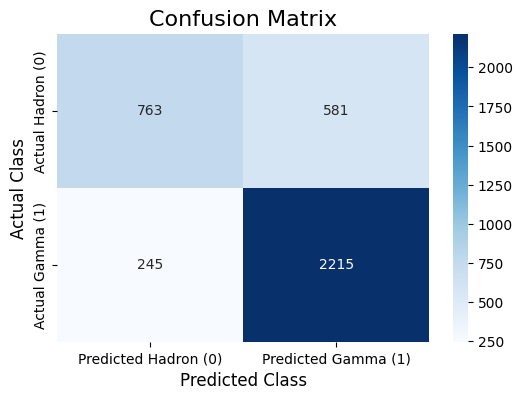


--- Confusion Matrix Breakdown ---
True Positives (Gamma correctly identified): 2215
True Negatives (Hadron correctly identified): 763
False Positives (Hadron mistaken for Gamma): 581
False Negatives (Gamma mistaken for Hadron): 245


In [35]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Hadron (0)', 'Predicted Gamma (1)'],
            yticklabels=['Actual Hadron (0)', 'Actual Gamma (1)'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

print("\n--- Confusion Matrix Breakdown ---")
print(f"True Positives (Gamma correctly identified): {tp}")
print(f"True Negatives (Hadron correctly identified): {tn}")
print(f"False Positives (Hadron mistaken for Gamma): {fp}")
print(f"False Negatives (Gamma mistaken for Hadron): {fn}")

In [36]:
# Calculate Precision
denominator_precision = tp + fp
if denominator_precision > 0:
    precision = tp / denominator_precision
else:
    precision = 0.0 # No positive predictions, so precision is 0

# Calculate Recall
denominator_recall = tp + fn
if denominator_recall > 0:
    recall = tp / denominator_recall
else:
    recall = 0.0 # No actual positives in the dataset, so recall is 0

# Calculate F1-Score
denominator_f1 = precision + recall
if denominator_f1 > 0:
    f1_score = 2 * (precision * recall) / denominator_f1
else:
    f1_score = 0.0 # If both precision and recall are 0


In [37]:
# --- Print the Results ---
print("--- Manual Performance Metrics ---")
print(f"Accuracy: {test_accuracy:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1_score:.4f}")

--- Manual Performance Metrics ---
Accuracy: 78.2860%
Precision: 0.7922
Recall:    0.9004
F1-Score:  0.8428
